In [1]:
import os
from typing import Tuple

from pydub import AudioSegment
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchaudio
import whisper

Download GTZAN dataset from `https://huggingface.co/datasets/marsyas/gtzan/resolve/main/data/genres.tar.gz` and add uncompressed result to `data/` folder

In [2]:
labels_map = {
    "blues": 0,
    "classical": 1,
    "country": 2,
    "disco": 3,
    "hiphop": 4,
    "jazz": 5,
    "metal": 6,
    "pop": 7,
    "reggae": 8,
    "rock": 9,
}

In [3]:
DATA_DIR = "data"

In [4]:
annotations = []
for label in labels_map:
    for file in os.listdir(f"{DATA_DIR}/genres/{label}"):
        annotation = {
            "filepath": f"{DATA_DIR}/genres/{label}/{file}",
            "label": labels_map[label]
        }
        annotations.append(annotation)

annotations_df = pd.DataFrame(annotations)

Each original audio sample is sliced into _SAMPLE_SLICES sub-samples

In [5]:
class CustomGTZANDataset(Dataset):
    _SAMPLE_SLICES = 10
    _TRAIN_FRAC = 0.9

    def __init__(self, annotations_df: pd.DataFrame, train: bool):
        train_annotations_df, test_annotations_df = train_test_split(
            annotations_df,
            train_size=int(self._TRAIN_FRAC * len(annotations_df)),
            stratify=annotations_df["label"],
            random_state=123,
        )
        self._annotations_df = train_annotations_df if train else test_annotations_df

    def __len__(self):
        return len(self._annotations_df) * self._SAMPLE_SLICES

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        audio_path = self._annotations_df.iloc[idx % len(self._annotations_df)]["filepath"]

        t = idx // len(self._annotations_df)
        milliseconds = 30000 / self._SAMPLE_SLICES
        audio_segment = AudioSegment.from_wav(audio_path)[
            milliseconds * t: milliseconds * t + milliseconds
        ]
        # temporarily write to disk
        audio_segment.export("tmp.wav", format="wav")
        waveform, sample_rate = torchaudio.load("tmp.wav")
        os.remove("tmp.wav")

        label = self._annotations_df.iloc[idx % len(self._annotations_df)]["label"]
        return whisper.log_mel_spectrogram(waveform), label

In [6]:
train_dataset = CustomGTZANDataset(annotations_df=annotations_df, train=True)

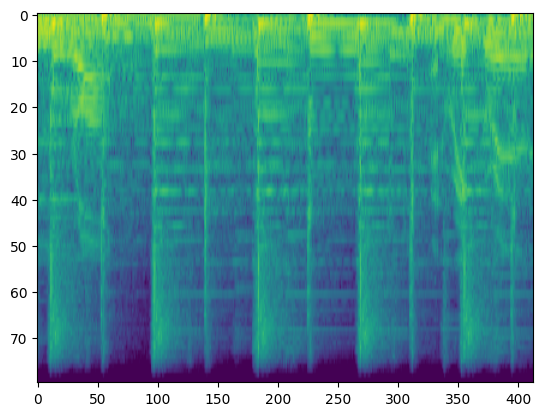

Log Mel Spectrogram example of class 2


In [7]:
img = train_dataset[0][0].squeeze(0)
plt.imshow(img, aspect="auto")
plt.show()
print(f"Log Mel Spectrogram example of class {train_dataset[0][1]}")

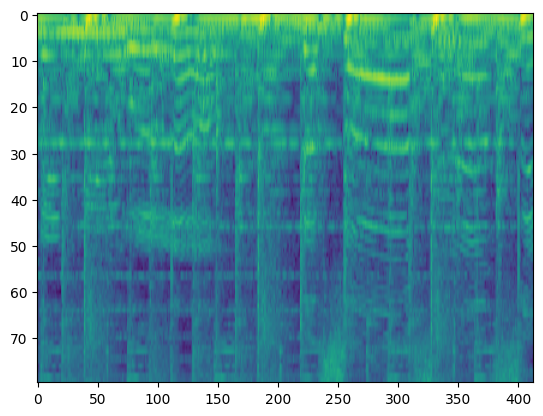

Log Mel Spectrogram example of class 3


In [8]:
img = train_dataset[3000][0].squeeze(0)
plt.imshow(img, aspect="auto")
plt.show()
print(f"Log Mel Spectrogram example of class {train_dataset[3000][1]}")